In [1]:
import os
import argparse
import json
import time
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from src.models import TemporalPC, MultilayertPC
from src.utils import *
from src.get_data import *
import matplotlib as mpl

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [31]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

            # Initialize hidden state with zeros
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            # One time step
            out, hn = self.rnn(x.to(dtype=torch.float32), h0)
            out = self.fc(out[:, -1, :]) 
            return out, hn


In [32]:
# sequences
num_classes = 8

seqs_al = [[0,1,2], [0,4,5]]
seqs_rl = [[0,2,3], [0,5,6]]
seqs_inf = [[1,2,3], [4,5,6]]
seqs = [seqs_al, seqs_rl, seqs_inf]

inputs = {}
labels = {}
for ni, name in enumerate(['al', 'rl', 'inf']):
    inp = [seq[:-1] for seq in seqs[ni]]
    inp = nn.functional.one_hot(torch.tensor(inp), num_classes= num_classes)
    lab = [seq[-1] for seq in seqs[ni]]
    lab = nn.functional.one_hot(torch.tensor(lab), num_classes= num_classes)
    inputs[name] = inp
    labels[name] = lab


In [33]:
# Data sets

batch_size = 1

datasets = {}
for nm in ['al', 'rl', 'inf']:
    train = TensorDataset(inputs[nm],labels[nm])
    train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
    datasets[nm] = train_loader

    

In [83]:
input_dim = num_classes   # input dimension
hidden_dim = 3 # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = num_classes   # output dimension


In [84]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
error = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
num_epochs = 50
seq_dim = 3 

loss_list = []
count_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (s, l) in enumerate(datasets['al']):
        
        train  = s.long()
        lbl = l.to(dtype=torch.float32)
    
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs,_ = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, lbl)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        loss_list.append(loss.data)
        
        count += 1
        
        if count % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inp_seq, lbls in datasets['inf']:
                inp_seq = inp_seq.long()
                
                # Forward propagation
                outputs,_ = model(inp_seq)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                targeted = torch.max(lbls.data, 1)[1]
                # Total number of labels
                total += lbls.size(0)
                
                correct += (predicted == targeted ).sum()
            
            accuracy = 100 * correct / float(total)
 
            #store loss and iteration
            
            count_list.append(count)
            accuracy_list.append(accuracy)
                
for epoch in range(num_epochs):
    for i, (s, l) in enumerate(datasets['rl']):
        
        train  = s.long()
        lbl = l.to(dtype=torch.float32)
    
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs,_ = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, lbl)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        loss_list.append(loss.data)
        
        count += 1
        
        if count % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inp_seq, lbls in datasets['inf']:
                inp_seq = inp_seq.long()
                
                # Forward propagation
                outputs,_ = model(inp_seq)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                targeted = torch.max(lbls.data, 1)[1]
                # Total number of labels
                total += lbls.size(0)
                
                correct += (predicted == targeted ).sum()
            
            accuracy = 100 * correct / float(total)
 
            #store loss and iteration
            
            count_list.append(count)
            accuracy_list.append(accuracy)
                


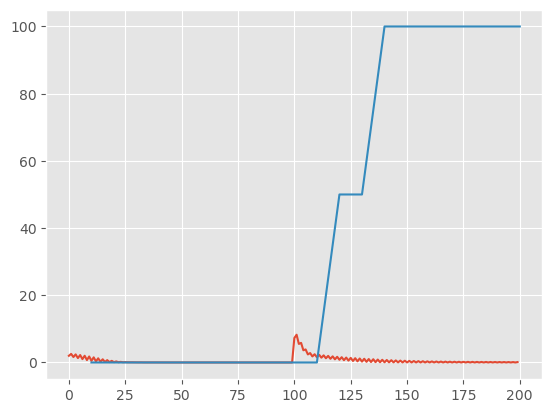

In [86]:
plt.plot(loss_list)
plt.plot(count_list, accuracy_list)

In [87]:
inp, lb = datasets['inf']
lb

[tensor([[[0, 0, 0, 0, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0]]]),
 tensor([[0, 0, 0, 0, 0, 0, 1, 0]])]

In [88]:
inputs['al'][0]

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]])

<StemContainer object of 3 artists>

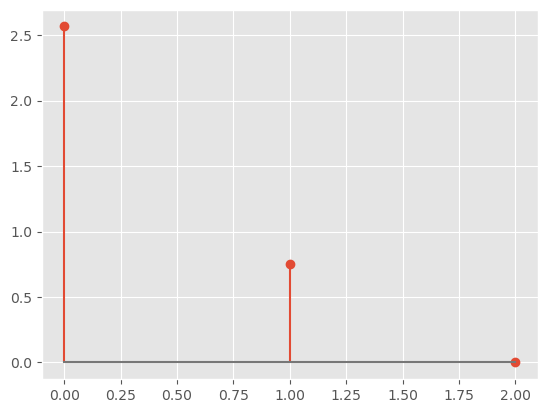

In [91]:
out, hid = model(inputs['inf'][0].unsqueeze(dim=0))
plt.stem(np.arange(hidden_dim), hid.detach().squeeze().numpy())

<StemContainer object of 3 artists>

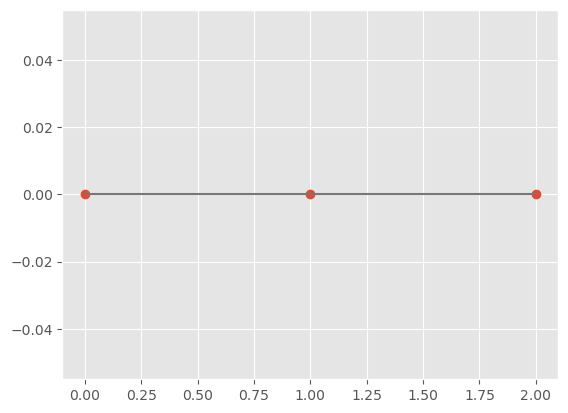

In [92]:
out, hid = model(inputs['inf'][1].unsqueeze(dim=0))
plt.stem(np.arange(hidden_dim), hid.detach().squeeze().numpy())

In [186]:
torch.argmax(model(lb[0]))

tensor(3)

In [187]:
r, t = model(inp[0])

ValueError: not enough values to unpack (expected 2, got 1)